## DCGAN Variation
### Experience replay

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### MNIST dataset

In [2]:
data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
# normalize X
X = (data[:,1:]/255).reshape(-1,28,28,1)
# one hot encode y
y = np.zeros(shape=(len(X),10),dtype=int)
y[np.arange(len(data)),data[:,0].astype(int)] = 1
# subsample X (for faster training)
X_copy = X.copy()
mask = np.random.choice(range(len(X)),size=2000)
X = X[mask]

In [3]:
from keras.models import Model, Sequential
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Flatten
from keras.layers import Dense, Input, Reshape, ReLU, Conv2DTranspose, Activation

Using TensorFlow backend.


### Generate models

In [4]:
def build_models():
    '''Generate keras models for a functional DCGAN'''
    # discriminator
    input_layer = Input(shape = X[0].shape)
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU(0.2)(x)
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = LeakyReLU(0.2)(x)
    x = Convolution2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    output = (Dense(1,activation='sigmoid'))(x)

    discriminator = Model(inputs=input_layer,outputs=output)
    discriminator.compile(optimizer='adam',loss='binary_crossentropy')

    # generator
    input_layer = Input(shape=(1,1,100))
    x = Dense(2048)(input_layer)
    x = Reshape(target_shape=(4, 4, 128))(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(filters=64,kernel_size=(5, 5),strides=(2, 2),padding='same',output_padding=(0,0))(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    output = Activation('tanh')(x)

    generator = Model(inputs = input_layer,outputs = output)
    generator.compile(optimizer='adam',loss='binary_crossentropy')

    # GAN
    gan = Sequential()
    discriminator.trainable = False
    gan.add(generator)
    gan.add(discriminator)

    gan.compile(optimizer='adam',loss='binary_crossentropy')
    
    return discriminator, generator, gan

### Training models with experience replay

In [5]:
# initialize models
discriminator, generator, gan = build_models()

# setup parameters
epochs = 200
print_fq = 20
batch_size = 100
generator_ratio = 2

# inital experience for replay (experience will save the latent values rather than the actual images)
ex_size = 10*batch_size
experience = np.random.normal(size=(ex_size,)+(1,1,100))

for epoch in range(epochs):
    if ((epoch+1)%print_fq==0):
        print('Epoch: ',epoch+1)
    for batch in range(len(X)//batch_size):
        # normalize data to -1, 1 (works better that way, also in line with tanh output of generator)
        x_b = X[batch*batch_size:(batch+1)*batch_size]*2-1
        y_b = y[batch*batch_size:(batch+1)*batch_size]
        # randomly generate image and add them to the experience
        z = np.random.normal(size=((len(x_b),)+(1,1,100)))
        experience = np.concatenate((z,experience))
        # truncate experience
        experience = experience[:ex_size]
        # sample from experience
        images = experience[np.random.choice(range(len(experience)),replace=False,size=len(x_b))]
        # generate images from latent values
        images = generator.predict(images)
        # generate labels for discriminator
        real = np.ones(len(x_b)) - np.random.random(size=len(x_b))*0.2
        fake = np.zeros(len(x_b)) + np.random.random(size=len(x_b))*0.2
        
        # train discriminator once
        discriminator.trainable = True
        discriminator.train_on_batch(x_b,real)
        discriminator.train_on_batch(images,fake)
        
        # train generator n times
        for i in range(generator_ratio):
            discriminator.trainable = False
            # generate new images

            z = np.random.normal(size=((len(x_b),)+(1,1,100)))
            experience = np.concatenate((z,experience))
            experience = experience[:ex_size]
            z = experience[np.random.choice(range(len(experience)),replace=False,size=len(x_b))]
            # discriminator should be fooled into accepting those images
            fool = np.ones(len(x_b)) - np.random.random(size=len(x_b))*0.2
            gan.train_on_batch(z,fool)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80
Epoch:  100
Epoch:  120
Epoch:  140
Epoch:  160
Epoch:  180
Epoch:  200


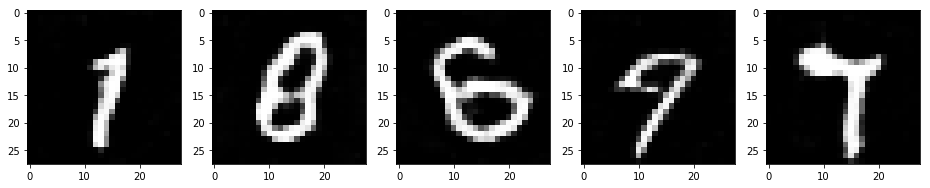

In [13]:
z = np.random.normal(size=(5,1,1,100))

im = generator.predict(z)

fig, ax = plt.subplots(ncols=5,figsize=(16,6))
for i in range(5):
    ax[i].imshow(im[i].reshape(28,28),cmap='gray')
plt.show()